### Imports

In [1]:
# Problem 1
import tarfile
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import os
import shutil

# Problem 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Helper functions

In [ ]:
# Mapping of Swedish month names to numerical format
swedish_months = {
    'januari': '01',
    'februari': '02',
    'mars': '03',
    'april': '04',
    'maj': '05',
    'juni': '06',
    'juli': '07',
    'augusti': '08',
    'september': '09',
    'oktober': '10',
    'november': '11',
    'december': '12'
}

# Convert Swedish date to 'YYYY-MM-DD' format
def clean_date(date_str):
    # date_str is expected to be in the format '28 oktober 2023'
    parts = date_str.strip().split(' ')
    if len(parts) != 3:
        return ''  # Return empty string if format is unexpected
    day, swedish_month, year = parts
    month = swedish_months.get(swedish_month.lower())
    if month is None:
        return ''  # Return empty string if month is not found
    date_formatted = f'{year}-{month}-{day.zfill(2)}'
    return date_formatted

# Parse area text to extract boarea, biarea, and number of rooms
def parse_area_text(area_text):
    area_text = area_text.replace('\u00a0', ' ').strip()
    area_text = re.sub(r'\s+', ' ', area_text)
    boarea = None
    biarea = None
    rooms = None

    # Extract boarea and biarea
    # Match patterns like '94 + 87 m²' or '94 m²'
    area_match = re.match(r'(\d+)\s*(?:\+\s*(\d+))?\s*m²', area_text)
    if area_match:
        boarea = int(area_match.group(1))
        if area_match.group(2):
            biarea = int(area_match.group(2))

    # Extract number of rooms
    rooms_match = re.search(r'(\d+)\s*rum', area_text)
    if rooms_match:
        rooms = int(rooms_match.group(1))

    return boarea, biarea, rooms

# Extract listing information from a listing HTML element
def extract_listing_info(listing_html):
    listing_soup = BeautifulSoup(str(listing_html), 'html.parser')

    # Extract area information
    area_tag = listing_soup.find('div', class_='sold-property-listing__subheading sold-property-listing__area')
    if area_tag:
        area_text = area_tag.get_text(strip=True)
    else:
        area_text = ''

    boarea, biarea, rooms = parse_area_text(area_text)

    # Calculate totalarea if both boarea and biarea are available
    if boarea is not None and biarea is not None:
        totalarea = boarea + biarea
    else:
        totalarea = ''  # Leave blank as per instructions

    # Extract date of sale
    date_tag = listing_soup.find('span', class_='hcl-label hcl-label--state hcl-label--sold-at')
    if date_tag:
        date_text = date_tag.get_text(strip=True)
        date_match = re.search(r'Såld\s+(.*)', date_text)
        if date_match:
            date_str = date_match.group(1)
            date_of_sale = clean_date(date_str)
        else:
            date_of_sale = ''
    else:
        date_of_sale = ''

    # Extract address
    address_tag = listing_soup.find('h2', class_='sold-property-listing__heading qa-selling-price-title hcl-card__title')
    if address_tag:
        address = address_tag.get_text(strip=True)
    else:
        address = ''

    # Extract location
    location_tag = listing_soup.find('div', class_='sold-property-listing__location')
    if location_tag:
        location_text = location_tag.get_text()
        # Remove 'VillaVilla' if present
        if "VillaVilla" in location_text:
            location = location_text.split("VillaVilla", 1)[1].strip()
        else:
            location = location_text.strip()
        location = re.sub(r'\s+', ' ', location)
    else:
        location = ''

    # Extract plot area
    plotarea_tag = listing_soup.find('div', class_='sold-property-listing__land-area')
    if plotarea_tag:
        plotarea_text = plotarea_tag.get_text(strip=True)
        # Extract all digits, including those separated by spaces
        plotarea_digits = re.findall(r'\d+', plotarea_text)
        if plotarea_digits:
            plotarea = int(''.join(plotarea_digits))
        else:
            plotarea = ''
    else:
        plotarea = ''

    # Extract closing price
    closingprice_tag = listing_soup.find('span', class_='hcl-text hcl-text--medium')
    if closingprice_tag:
        closingprice_text = closingprice_tag.get_text(strip=True)
        # Extract all digits, including those separated by spaces
        closingprice_digits = re.findall(r'\d+', closingprice_text)
        if closingprice_digits:
            closingprice = int(''.join(closingprice_digits))
        else:
            closingprice = ''
    else:
        closingprice = ''

    # Return the extracted information as a dictionary
    listing_info = {
        'Date of sale': date_of_sale,
        'Address': address,
        'Location': location,
        'Boarea': float(boarea) if boarea is not None else '',
        'Biarea': float(biarea) if biarea is not None else '',
        'Totalarea': float(totalarea) if totalarea != '' else '',
        'Number of rooms': float(rooms) if rooms is not None else '',
        'Plot area': float(plotarea) if plotarea != '' else '',
        'Closing price': int(closingprice) if closingprice != '' else ''
    }

    return listing_info

# List all HTML files from the given root directory
def get_all_html_files(root_path):
    return Path(root_path).glob("**/*.html")

# Problem 1: Scraping house prices

In [ ]:
# Extract HTML files from tar file
file_path = "kungalv_slutpriser.tar.gz"

if file_path.endswith("tar.gz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()
elif file_path.endswith("tar"):
    tar = tarfile.open(file_path, "r:")
    tar.extractall()
    tar.close()

# Set root folder path
html_root = Path("./kungalv_slutpriser/")

# Empty list to store data
listing_elements = []

# Loop through each HTML file and extract data
for html_file in tqdm(list(get_all_html_files(html_root)), desc='Processing HTML files'):
    with open(html_file, encoding='utf-8') as fp:
        soup = BeautifulSoup(fp, 'html.parser')

    # Find all listings on the HTML page
    listings = soup.find_all('li', class_='sold-results__normal-hit')

    for listing_html in listings:
        listing_info = extract_listing_info(listing_html)
        listing_elements.append(listing_info)

# Creating dataframe with scraped data
df = pd.DataFrame(listing_elements)

# Export to CSV
df.to_csv("problem1.csv", index=False)

# Delete the extracted_files folder after processing
shutil.rmtree("kungalv_slutpriser/")
print("Deleted the folder kungalv_slutpriser after processing.")

/var/folders/qw/7m__jx3s1d7c59k4hvfhjv940000gn/T/ipykernel_67620/2339155613.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()
Processing HTML files: 100%|██████████| 40/40 [00:04<00:00,  9.79it/s]

Deleted the folder kungalv_slutpriser after processing.


In [ ]:
# Check the dataframe
df

,Date of sale,Address,Location,Boarea,Biarea,Totalarea,Number of rooms,Plot area,Closing price
0,2017-11-23,Sjöhåla 580,"Kovikshamn, Kungälvs kommun",94.0,87.0,181.0,5.0,1068.0,3100000
1,2017-11-18,Galeasgatan 15,"Kungälv, Kungälvs kommun",103.0,64.0,167.0,5.0,610.0,3850000
2,2017-11-17,Västerhöjdsvägen 36,"Kärna, Kungälvs kommun",107.0,,,5.0,258.0,4000000
3,2017-11-16,Gråstensvägen 19,"Kode Halltorp, Kungälvs kommun",94.0,,,5.0,1197.0,3200000
4,2017-11-16,Hägnan 135,"KAREBY, Kungälvs kommun",235.0,,,6.0,104335.0,8800000
...,...,...,...,...,...,...,...,...,...
1968,2016-04-14,Olvonvägen 71,"Kungälv - Romelanda, Kungälvs kommun",115.0,115.0,230.0,6.0,2056.0,4725000
1969,2016-04-14,Rättarevägen 16,"Ytterby, Kungälvs kommun",105.0,122.0,227.0,6.0,732.0,4300000
1970,2016-04-12,Ametistvägen 11,"Kode, Kungälvs kommun",107.0,,,4.0,806.0,2850000
1971,2016-04-09,Rådalsvägen 25 Havsutsikt,"Aröd, Kungälvs kommun",88.0,,,3.0,1462.0,2995000


# Problem 2: Analyzing 2022 house sales

In [ ]:
# Convert 'Date of sale' to datetime
df['Date of sale'] = pd.to_datetime(df['Date of sale'], errors='coerce')

# Filter for sales in 2022
df_2022 = df[df['Date of sale'].dt.year == 2022].copy()

# Reset the index
df_2022.reset_index(drop=True, inplace=True)

# Display the first few rows of the 2022 data
print(df_2022.head())

  Date of sale               Address                   Location Boarea Biarea  \
0   2022-01-26        Häroldsgatan 5   Centrum, Kungälvs kommun  141.0          
1   2022-01-25      Långåkersgatan 6  Centralt, Kungälvs kommun  140.0   36.0   
2   2022-01-24  Västerhöjdsvägen 111     Kärna, Kungälvs kommun  103.0          
3   2022-01-22         Valtersäng 11  Trankärr, Kungälvs kommun  162.0          
4   2022-01-21         Skvaltvägen 3   Diseröd, Kungälvs kommun  180.0  145.0   

  Totalarea Number of rooms Plot area  Closing price  
0                       7.0     799.0        5700000  
1     176.0             5.0     733.0        7000000  
2                       5.0     423.0        2500000  
3                       4.0     808.0        6150000  
4     325.0             8.0    1352.0        5975000  


### Compute the five-number summary of the closing prices (minimum, maximum, median, first and third quartile).

In [ ]:
# Ensure 'Closing price' is numeric
df_2022['Closing price'] = pd.to_numeric(df_2022['Closing price'], errors='coerce')

# Compute the five-number summary
closing_price = df_2022['Closing price'].dropna()
minimum = closing_price.min()
Q1 = closing_price.quantile(0.25)
median = closing_price.median()
Q3 = closing_price.quantile(0.75)
maximum = closing_price.max()

# Print the five-number summary
print("Five-number summary of Closing Prices in 2022:")
print(f"Minimum: {minimum}")
print(f"First Quartile (Q1): {Q1}")
print(f"Median: {median}")
print(f"Third Quartile (Q3): {Q3}")
print(f"Maximum: {maximum}")

Five-number summary of Closing Prices in 2022:
Minimum: 1650000
First Quartile (Q1): 4012500.0
Median: 5000000.0
Third Quartile (Q3): 5795000.0
Maximum: 10500000


### Construct a histogram of the closing prices. In your report, describe how you selected the number of bins (or equivalently the bin width).

In [ ]:
# Calculate IQR
IQR = Q3 - Q1

# Number of observations
n = closing_price.count()

# Calculate bin width
bin_width = 2 * IQR / n**(1/3)

# Calculate number of bins
num_bins = int((maximum - minimum) / bin_width)

print(f"Calculated number of bins: {num_bins}")

Calculated number of bins: 14


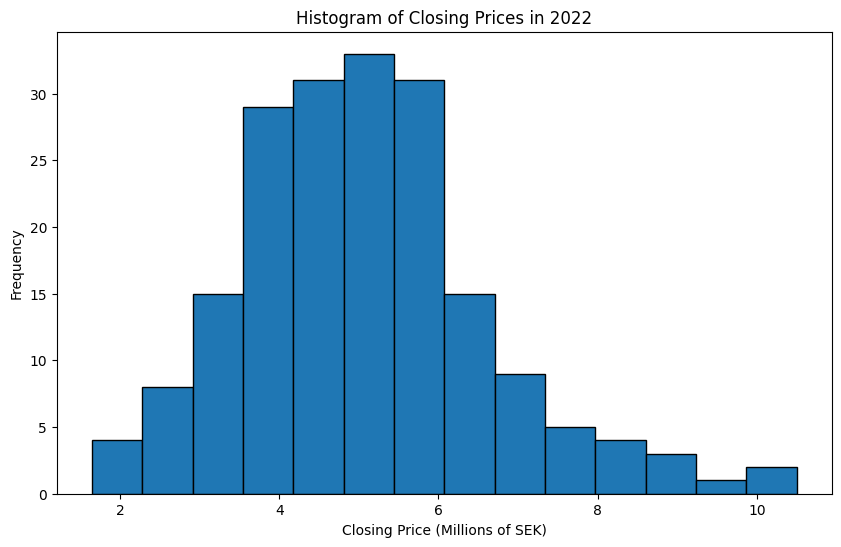

In [ ]:
# Scale closing prices to millions
closing_price_millions = closing_price / 1e6

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(closing_price_millions, bins=num_bins, edgecolor='black')
plt.title('Histogram of Closing Prices in 2022')
plt.xlabel('Closing Price (Millions of SEK)')
plt.ylabel('Frequency')
plt.savefig('closing_price_histogram.pdf', format='pdf')
plt.show()

### Construct a scatter plot that shows the relationship of the closing price with the boarea of the house.

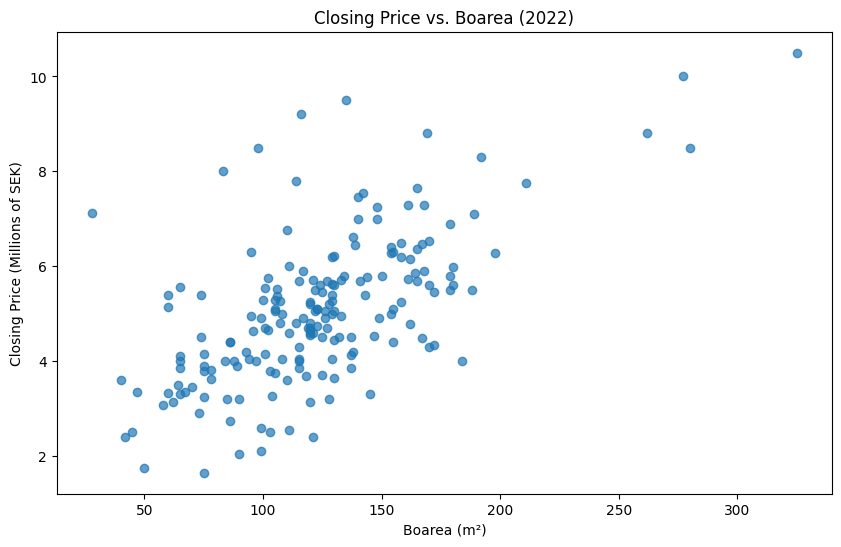

In [ ]:
# Scatter plot of Closing Price vs. Boarea
scatter_data = df_2022[['Boarea', 'Closing price']].dropna()
scatter_data['Closing price (Millions)'] = scatter_data['Closing price'] / 1e6

plt.figure(figsize=(10, 6))
plt.scatter(scatter_data['Boarea'], scatter_data['Closing price (Millions)'], alpha=0.7)
plt.title('Closing Price vs. Boarea (2022)')
plt.xlabel('Boarea (m²)')
plt.ylabel('Closing Price (Millions of SEK)')
plt.savefig('closing_price_vs_boarea.pdf', format='pdf')
plt.show()

### Finally, repeat the scatter plot, but instead of showing all observations in the same color, colorize the observations by the number of rooms in the house.

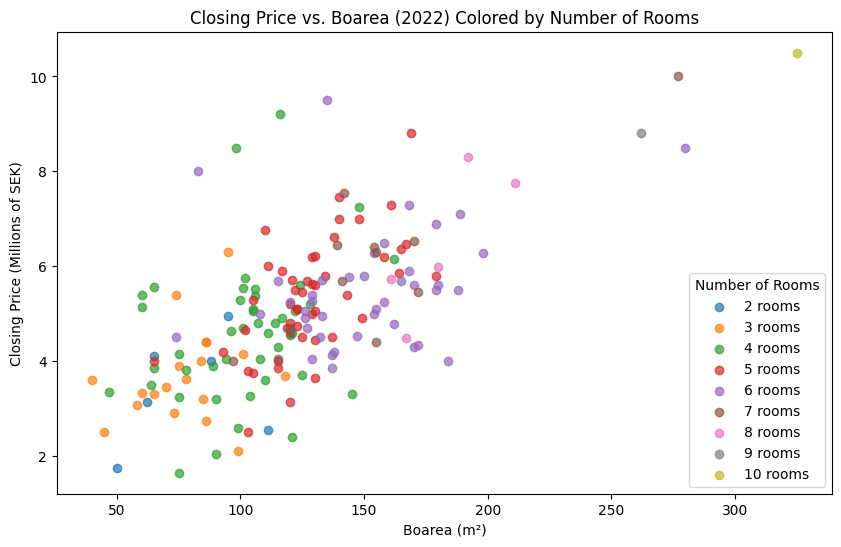

In [ ]:
# Scatter plot colored by Number of Rooms
df_2022['Number of rooms'] = pd.to_numeric(df_2022['Number of rooms'], errors='coerce')
scatter_data_color = df_2022[['Boarea', 'Closing price', 'Number of rooms']].dropna()
scatter_data_color['Closing price (Millions)'] = scatter_data_color['Closing price'] / 1e6

# Get unique numbers of rooms
rooms_unique = scatter_data_color['Number of rooms'].unique()
rooms_unique.sort()

# Define a discrete color map
colors = plt.cm.tab10.colors  # Use tab10 colormap which has 10 discrete colors
color_dict = {room: colors[i % len(colors)] for i, room in enumerate(rooms_unique)}

# Plot the scatter plot
plt.figure(figsize=(10, 6))

for room in rooms_unique:
    room_data = scatter_data_color[scatter_data_color['Number of rooms'] == room]
    plt.scatter(
        room_data['Boarea'],
        room_data['Closing price (Millions)'],
        color=color_dict[room],
        label=f'{int(room)} rooms',
        alpha=0.7
    )

plt.title('Closing Price vs. Boarea (2022) Colored by Number of Rooms')
plt.xlabel('Boarea (m²)')
plt.ylabel('Closing Price (Millions of SEK)')
plt.legend(title='Number of Rooms')
plt.savefig('closing_price_vs_boarea_colored.pdf', format='pdf')
plt.show()